In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [2]:
train_df = pd.read_pickle('./01_train.dat')

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])


(634284, 360447)

In [3]:
WOE_LIST = joblib.load('./woe_feature.dat')
CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST
categorical=[]
for item in predictors:
    if (item in CATE_LIST):
        categorical.append(item)

In [28]:
num_boosting_round = 3000
early_stop_round = 100

In [46]:
params = {
    
    'objective': 'binary',
    'metric': 'auc',
    'use_missing' : True,
    #'is_unbalance': True,
    'scale_pos_weight': 98,
    'learning_rate': 0.05,
    'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'colsample_bytree': 0.7,
    'subsample': 0.85,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.01,  # L1 regularization term on weights
    'reg_lambda': 0.1,  # L2 regularization term on weights
    'nthread': 40,
    'n_estimators': num_boosting_round,
    'verbose': -1,
}

rf = {
    'boosting_type': 'rf',
}
rf.update(params)

dart = {
    'boosting_type': 'dart',
}
dart.update(params)

gbdt = {
    'boosting_type': 'gbdt',
}
gbdt.update(params)

param_list = [rf,gbdt,dart]

In [47]:
model_list  =[]

for idx in tqdm(range(0,5)):
    
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
    
    Val_DataSet = train_df[train_df.index.isin(DateFold[idx])].reset_index(drop=True)
    X_train = under_sample_train[predictors]
    y_train = under_sample_train['Fraud']

    X_test = Val_DataSet[predictors]
    y_test = Val_DataSet['Fraud']
    
    for item_params in (param_list):
        gbm = lgb.LGBMClassifier(**item_params)
        print('starting fit model...')
        gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='auc',early_stopping_rounds=early_stop_round,verbose=100,categorical_feature=categorical)
        model_list.append(gbm)    

    

  0%|          | 0/5 [00:00<?, ?it/s]

starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.895769
Early stopping, best iteration is:
[45]	valid_0's auc: 0.897065
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.948038
[200]	valid_0's auc: 0.970414
[300]	valid_0's auc: 0.973596
[400]	valid_0's auc: 0.974989
[500]	valid_0's auc: 0.975403
[600]	valid_0's auc: 0.975917
[700]	valid_0's auc: 0.976087
[800]	valid_0's auc: 0.976349
[900]	valid_0's auc: 0.976258
[1000]	valid_0's auc: 0.97639
[1100]	valid_0's auc: 0.976307
Early stopping, best iteration is:
[1034]	valid_0's auc: 0.976486
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.934861
[200]	valid_0's auc: 0.940197
[300]	valid_0's auc: 0.950968
[400]	valid_0's auc: 0.961171
[500]	valid_0's auc: 0.967543
[600]	valid_0's auc: 0.970073
[700]	valid_0's auc: 0.971229
[800]	valid_0's auc: 0.972382
[900]	valid_0'

 20%|██        | 1/5 [01:31<06:05, 91.44s/it]

Early stopping, best iteration is:
[1453]	valid_0's auc: 0.97581
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.933029
Early stopping, best iteration is:
[79]	valid_0's auc: 0.933426
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.963989
[200]	valid_0's auc: 0.978256
[300]	valid_0's auc: 0.979655
[400]	valid_0's auc: 0.980166
[500]	valid_0's auc: 0.980548
[600]	valid_0's auc: 0.980668
[700]	valid_0's auc: 0.980643
Early stopping, best iteration is:
[615]	valid_0's auc: 0.980709
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.948879
[200]	valid_0's auc: 0.954907
[300]	valid_0's auc: 0.964937
[400]	valid_0's auc: 0.975463
[500]	valid_0's auc: 0.978427
[600]	valid_0's auc: 0.979117
[700]	valid_0's auc: 0.979425
[800]	valid_0's auc: 0.979695
[900]	valid_0's auc: 0.979802
[1000]	valid_0's auc: 0.980056
[1100]	val

 40%|████      | 2/5 [03:08<04:39, 93.16s/it]

Early stopping, best iteration is:
[1873]	valid_0's auc: 0.98142
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.949874
Early stopping, best iteration is:
[71]	valid_0's auc: 0.950135
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.97106
[200]	valid_0's auc: 0.980469
[300]	valid_0's auc: 0.982345
[400]	valid_0's auc: 0.982952
[500]	valid_0's auc: 0.983307
[600]	valid_0's auc: 0.983735
[700]	valid_0's auc: 0.984029
[800]	valid_0's auc: 0.984306
[900]	valid_0's auc: 0.98444
[1000]	valid_0's auc: 0.984549
[1100]	valid_0's auc: 0.98473
[1200]	valid_0's auc: 0.984747
[1300]	valid_0's auc: 0.984862
[1400]	valid_0's auc: 0.984931
[1500]	valid_0's auc: 0.984975
[1600]	valid_0's auc: 0.98502
[1700]	valid_0's auc: 0.985057
Early stopping, best iteration is:
[1668]	valid_0's auc: 0.985091
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	

 60%|██████    | 3/5 [04:50<03:11, 95.84s/it]

Early stopping, best iteration is:
[1799]	valid_0's auc: 0.984338
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.954405
Early stopping, best iteration is:
[28]	valid_0's auc: 0.955367
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.966649
[200]	valid_0's auc: 0.976852
[300]	valid_0's auc: 0.978602
[400]	valid_0's auc: 0.978879
[500]	valid_0's auc: 0.979479
[600]	valid_0's auc: 0.979786
[700]	valid_0's auc: 0.980113
[800]	valid_0's auc: 0.980191
Early stopping, best iteration is:
[732]	valid_0's auc: 0.980327
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.955603


 80%|████████  | 4/5 [05:24<01:17, 77.32s/it]

Early stopping, best iteration is:
[13]	valid_0's auc: 0.95699
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.917573
Early stopping, best iteration is:
[22]	valid_0's auc: 0.918103
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.954577
[200]	valid_0's auc: 0.980165
[300]	valid_0's auc: 0.982454
[400]	valid_0's auc: 0.983434
[500]	valid_0's auc: 0.983903
[600]	valid_0's auc: 0.98422
[700]	valid_0's auc: 0.984387
[800]	valid_0's auc: 0.984513
[900]	valid_0's auc: 0.984613
[1000]	valid_0's auc: 0.984592
Early stopping, best iteration is:
[907]	valid_0's auc: 0.98467
starting fit model...
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.937284
[200]	valid_0's auc: 0.942646
[300]	valid_0's auc: 0.955462
[400]	valid_0's auc: 0.972116
[500]	valid_0's auc: 0.978105
[600]	valid_0's auc: 0.980052
[700]	valid_0's auc: 0.981205
[800]	valid_0'

100%|██████████| 5/5 [06:44<00:00, 77.94s/it]

Early stopping, best iteration is:
[1244]	valid_0's auc: 0.983944


In [56]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
val_df1 = val_df.head(180000)
val_df2 = val_df[~val_df.index.isin(list(val_df1.index))]

In [59]:
val_r_neg=pd.DataFrame()
for idx in tqdm(range(0,len(model_list))):
    model_neg = model_list[idx]
    val_neg = model_neg.predict_proba(val_df2[predictors])
    val_r_neg[idx] = pd.DataFrame(val_neg)[1]
    
    

100%|██████████| 15/15 [01:33<00:00,  6.12s/it]


Ant-Score: 0.3941491553358055


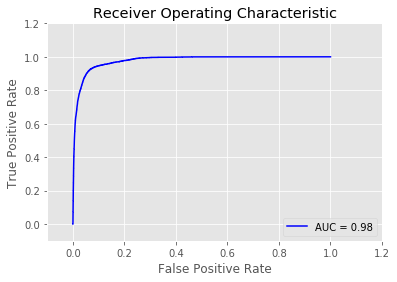

In [60]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)
_,_,_ = atecml.data.accuracy_validation(val_df2['Fraud'],neg_mean)

In [61]:
vote_list =[]
for idx in tqdm(range(0,len(model_list))):
    name = 'model_' + str(idx)
    clf = model_list[idx]
    vote_list.append((name,clf))

100%|██████████| 15/15 [00:00<00:00, 78643.20it/s]


In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf=VotingClassifier(estimators=vote_list,voting='soft',n_jobs=40)
voting_clf.fit(val_df1[predictors],val_df1['Fraud'])

In [ ]:
foo = voting_clf.predict_proba(val_df2[predictors])

In [ ]:
_,_,_ = atecml.data.accuracy_validation(val_df2['Fraud'],pd.DataFrame(foo)[1])

In [13]:
import joblib
#joblib.dump(pos_model_list,'./pos_model_list.dat')
#joblib.dump(score_posA,'./score_pos.dat')
joblib.dump(neg_model_list,'./neg_model_list.dat')
joblib.dump(score_negA,'./score_neg.dat')

['./score_neg.dat']

In [17]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)

val_r_pos=pd.DataFrame()
val_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(neg_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
    val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
    #val_r_pos[idx] = 1 - val_pos
    val_r_neg[idx] = val_neg

100%|██████████| 5/5 [01:45<00:00, 21.16s/it]


In [18]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)

Ant-Score: 0.516549220585095


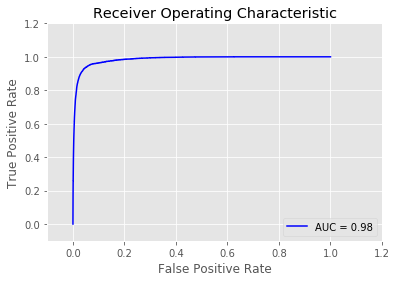

In [19]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [20]:
from sklearn.ensemble import VotingClassifier

In [21]:
voting_clf=VotingClassifier(estimators=[('a1',neg_model_list[0]),('rf',neg_model_list[1]),('svc',neg_model_list[2])],voting='soft')


In [25]:
voting_clf.fit(val_df[predictors],val_df['Fraud'])

TypeError: Cannot clone object '<lightgbm.basic.Booster object at 0x7f429577b0b8>' (type <class 'lightgbm.basic.Booster'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [26]:
foo = neg_model_list[1]

In [30]:
foo.feature_importance()

array([ 588,  523,  739, 1664,  632, 1595, 3183,  763,  795,  694, 1141,
        752,  593, 1636, 2249,  536, 1290, 1753, 1773,  237,  405,  230,
        307,  567,  814,  757,  749,  349,  384, 1078, 1126,  515,  538,
        457,  459,    5,   11,   19,   13,    1,   18,   19,   34,    9,
         22,   41,   34,  549,  445,  549,  390, 1024,  996,  809,  501,
        366,  450,  621,   61,  184,   26,  265,  318,  169,  185,  200,
        102,  132,  136,  105,  133,  184,  285,  215,  202,  299,  281,
        228,  224,  623, 1100, 1862,  707,  939,  999,  979,    7,    3,
         33,   63,  238,   91,   83,   65,  116,  168,  124,   73,  285,
        376,  978,  317,  386,  470,  633, 1396,  158,  192,  182,  451,
         56,   65,  175,   96,   61,   70,   80,   68,   71,  124,   90,
         66,   61,  113,  128,   88,  151,  118,   64,  125,  131,  138,
        117,  216,   69,   52,   82,  109,  103,   78,   79,  132,  116,
        157,  152,  125,  102,  201,   83,   72,  1

In [ ]:
test_df = pd.read_pickle('./01_test.dat')

In [ ]:
test_r_pos=pd.DataFrame()
test_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(pos_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #test_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
    test_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)
    #test_r_pos[idx] = 1 - test_pos
    test_r_neg[idx] = test_neg

In [ ]:
neg_mean = test_r_neg.mean(axis=1)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = neg_mean

In [ ]:
result[['id','score']].to_csv('./submit_2018_07_05_01.csv',index=False)

In [ ]:
result